In [141]:
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.nn import ReLU, Softmax, Sigmoid
from tqdm import tqdm
from torch_geometric.data import HeteroData
from torch_geometric.nn import Linear, SAGEConv, Sequential, to_hetero
from torch_geometric.loader import HGTLoader
import torch_geometric.transforms as T


In [142]:
#data
data_DTYPES={"deviceID": "category","color": "category","itemID": "category","size": "category","manufacturerID": "category", "paymentMethod": "category"}
data_train =pd.read_csv('./orders_train.txt',delimiter=';',parse_dates=['orderDate','deliveryDate'],dtype = data_DTYPES)
data_test = pd.read_csv('./orders_class.txt',delimiter=';',parse_dates=['orderDate','deliveryDate'], dtype = data_DTYPES)
data_real = pd.read_csv('./realclass.txt',delimiter=';',dtype = data_DTYPES)
data_test = data_test.merge(data_real,on=['orderItemID'])

In [143]:

data_test['test']=True
data_train['test']=False

In [144]:
customer_purchase_times = data_train[['customerID','orderDate']].drop_duplicates().groupby(['customerID'])['orderDate'].count()
exsiting_customer = customer_purchase_times[customer_purchase_times>2].index.tolist()
repeat_customer =  data_test['customerID'].isin(exsiting_customer)


In [146]:
from sklearn.preprocessing import LabelEncoder
size_le = LabelEncoder().fit(pd.concat([data_train,data_test],axis = 0)['size'])
data_train['size'] =  size_le.transform(data_train['size'])
data_test['size'] = size_le.transform(data_test['size'])

color_le = LabelEncoder().fit(pd.concat([data_train,data_test],axis = 0)['color'])
data_train['color'] =  color_le.transform(data_train['color'])
data_test['color'] = color_le.transform(data_test['color'])

data_train['orderID']= data_train['customerID'].astype(str) +'_'+ data_train['orderDate'].apply(lambda x: x.strftime('%Y%m%d'))
data_test['orderID']= data_test['customerID'].astype(str) +'_'+ data_test['orderDate'].apply(lambda x: x.strftime('%Y%m%d'))

order_le = LabelEncoder().fit(pd.concat([data_train,data_test],axis = 0)['orderID'])
data_train['orderID'] =  order_le.transform(data_train['orderID'])
data_test['orderID'] = order_le.transform(data_test['orderID'])

data_train.rename(columns = {'itemID':'articleID'},inplace=True)
data_test.rename(columns = {'itemID':'articleID'},inplace=True)


In [148]:
state_le = LabelEncoder().fit(pd.concat([data_train,data_test],axis = 0)['state'])
data_train['state'] =  state_le.transform(data_train['state'])
data_test['state'] = state_le.transform(data_test['state'])

In [150]:
salutation_le = LabelEncoder().fit(pd.concat([data_train,data_test],axis = 0)['salutation'])
data_train['salutation'] =  salutation_le.transform(data_train['salutation'])
data_test['salutation'] = salutation_le.transform(data_test['salutation'])

In [154]:
def graph_build(df,valdata=False,data_train=None):
    df = df.copy()
    df['quantity']=1
    df['value'] = df['quantity'] * df['price']
    df['month']= df['orderDate'].dt.month/11
    df['wday']= df['orderDate'].dt.day_of_week/6
    df['order_size'] = df.groupby(['orderID'])['quantity'].transform('sum')/100
    df['order_value'] = df.groupby(['orderID'])['value'].transform('sum')/5000
    df['order_avg_value'] = df.groupby(['orderID'])['value'].transform('mean')/1000
    
    df['price'] = np.log1p(df['price'])
    
    data = HeteroData()
    
    if valdata:        
        for col in ['customerID', 'orderID', 'articleID','color','size','manufacturerID','state']:
            # Map IDs to consecutive integers:
            inds = np.unique(data_train[[col]].values)
            inds_dict = dict(zip(inds,range(len(inds))))
            inds_test = np.unique(df.loc[df[col].map(inds_dict).isna(),col].values)
            inds_test_dict = dict(zip(inds_test,range(len(inds),len(inds)+len(inds_test))))
            inds_dict.update(inds_test_dict)
            df[col] = df[col].map(inds_dict)
            
    
    else: 
        for col in ['customerID', 'orderID', 'articleID','color','size','manufacturerID','state']:
            # Map IDs to consecutive integers:
            _,df[col] = np.unique(df[[col]].values, return_inverse=True)        


    order_feat = df.groupby(['orderID'])[['wday','month','order_size','order_value','order_avg_value']].first()
    
    article_feat1 = df.groupby(['articleID'])['price'].mean()/10
    article_feat2 = df.groupby(['articleID'])['manufacturerID'].first()
    article_feat = pd.concat([article_feat1,article_feat2],axis=1)


    for col in ['customerID', 'orderID', 'articleID']:
        data[col].node_id = torch.from_numpy(np.unique(df[[col]].values))


    data['orderID'].x =  torch.from_numpy(order_feat.values[:,1:]).to(torch.float)
    data['articleID'].x =  torch.from_numpy(article_feat1.values).to(torch.float).unsqueeze(1)
    data['articleID'].productGroup =  torch.from_numpy(article_feat2.values).to(torch.long)
    data['customerID'].state =  torch.from_numpy(df.groupby(['customerID'])['state'].first().values).to(torch.long)
    data['customerID'].salutation =  torch.from_numpy(df.groupby(['customerID'])['salutation'].first().values).to(torch.long)

    col = torch.from_numpy(df.groupby(['customerID','orderID']).head(1)['orderID'].values)
    row = torch.from_numpy(df.groupby(['customerID','orderID']).head(1)['customerID'].values)
    data['customerID','make', 'orderID'].edge_index = torch.stack([row, col], dim=0)

    col = torch.from_numpy(df['orderID'].values)
    row = torch.from_numpy(df['articleID'].values)
    data['articleID','in', 'orderID'].edge_index = torch.stack([row, col], dim=0)


    data['articleID','in', 'orderID'].colorCode = torch.from_numpy(df[['color']].values).to(torch.long).squeeze()
    data['articleID','in', 'orderID'].sizeCode = torch.from_numpy(df[['size']].values).to(torch.long).squeeze()
        
    data['articleID','in', 'orderID'].edge_label = torch.from_numpy((df['returnShipment']>0).values).to(torch.float)
    data['articleID','in', 'orderID'].edge_attr = torch.from_numpy(df[['price']].values).to(torch.float)
    data['articleID','in', 'orderID'].mask = torch.from_numpy(df['test'].values)

    return data
    

In [155]:
data = graph_build(data_train)
data_test = graph_build(df = pd.concat([data_train,data_test.loc[repeat_customer,]],axis = 0),valdata=True,data_train=data_train)

In [156]:
data

HeteroData(
  customerID={
    node_id=[59754],
    state=[59754],
    salutation=[59754]
  },
  orderID={
    node_id=[138866],
    x=[138866, 4]
  },
  articleID={
    node_id=[3007],
    x=[3007, 1],
    productGroup=[3007]
  },
  (customerID, make, orderID)={ edge_index=[2, 138866] },
  (articleID, in, orderID)={
    edge_index=[2, 481092],
    colorCode=[481092],
    sizeCode=[481092],
    edge_label=[481092],
    edge_attr=[481092, 1],
    mask=[481092]
  }
)

In [157]:
data = T.ToUndirected()(data)

In [158]:
data_test = T.ToUndirected()(data_test)

In [159]:
data

HeteroData(
  customerID={
    node_id=[59754],
    state=[59754],
    salutation=[59754]
  },
  orderID={
    node_id=[138866],
    x=[138866, 4]
  },
  articleID={
    node_id=[3007],
    x=[3007, 1],
    productGroup=[3007]
  },
  (customerID, make, orderID)={ edge_index=[2, 138866] },
  (articleID, in, orderID)={
    edge_index=[2, 481092],
    colorCode=[481092],
    sizeCode=[481092],
    edge_label=[481092],
    edge_attr=[481092, 1],
    mask=[481092]
  },
  (orderID, rev_make, customerID)={ edge_index=[2, 138866] },
  (orderID, rev_in, articleID)={
    edge_index=[2, 481092],
    colorCode=[481092],
    sizeCode=[481092],
    edge_label=[481092],
    edge_attr=[481092, 1],
    mask=[481092]
  }
)

In [161]:
loader = HGTLoader(
    data,
    # Sample 512 nodes per type and per iteration for 4 iterations
    num_samples={key: [2048] * 6 for key in data.node_types},
    # Use a batch size of 128 for sampling training nodes of type order
    batch_size=2048,
    input_nodes=('orderID', None),
)



In [162]:
num_productgroup = np.int64(data_test["articleID"].productGroup.max().numpy()) + 1
num_size = np.int64(data_test['articleID','in', 'orderID'].sizeCode.max().numpy()) +1
num_color = np.int64(data_test['articleID','in', 'orderID'].colorCode.max().numpy()) +1
num_article = np.int64(data_test["articleID"].node_id.max().numpy()) +1
num_customer= np.int64(data_test["customerID"].node_id.max().numpy()) +1
num_state= np.int64(data_test["customerID"].state.max().numpy()) +1
num_salutation= np.int64(data_test["customerID"].salutation.max().numpy()) +1

In [165]:
from torch import Tensor

from torch_geometric.nn import GATConv,GATv2Conv,GENConv,GraphConv
from torch_geometric.utils import to_undirected
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(3 * hidden_channels, 2*hidden_channels)
        self.lin2 = Linear(2*hidden_channels, 1)

    def forward(self,  cus_order, article,edge_label_index,edge_attr):
        row, col = edge_label_index
       
        #z = torch.cat([order[col], article[row],edge_attr,cus_order[col]], dim=-1)
        z = torch.cat([ article[row],edge_attr,cus_order[col]], dim=-1)
        #z = torch.cat([edge_attr, edge_attr,edge_attr], dim=-1)
        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)     
    
   
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_order: Tensor, x_article: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_order = x_order[edge_label_index[1]]
        edge_feat_article = x_article[edge_label_index[0]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_order * edge_feat_article).sum(dim=-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.order_lin = torch.nn.Linear(4, hidden_channels)
        self.article_lin = torch.nn.Linear(1, hidden_channels)
        #self.orderID_emb = torch.nn.Embedding(data["orderID"].num_nodes, hidden_channels)
        self.articleID_emb = torch.nn.Embedding(num_article, hidden_channels)
        self.customerID_emb = torch.nn.Embedding(num_customer, hidden_channels)
        self.customer_lin = torch.nn.Linear(1, hidden_channels)
        self.productGroup_emb = torch.nn.Embedding(num_productgroup, hidden_channels)        
        self.sizeCode_emb = torch.nn.Embedding(num_size, hidden_channels)
        self.colorCode_emb = torch.nn.Embedding(num_color, hidden_channels)
        self.state_emb = torch.nn.Embedding(num_state, hidden_channels)
        self.salutation_emb = torch.nn.Embedding(num_salutation, hidden_channels)
        
        # Instantiate homogeneous GNN:
        #self.gnn_article_order = GATConv(hidden_channels, hidden_channels,add_self_loops= False,head=2)
        self.gnn_article_order = GENConv(hidden_channels, hidden_channels,bias = True,learn_t=True,learn_p=True)
        #self.gnn_article_order = NNConv(hidden_channels, hidden_channels, nn = torch.nn.Sequential(torch.nn.Linear(hidden_channels, hidden_channels), torch.nn.ReLU()), aggr='add')
        #self.gnn_customer_order = SAGEConv(hidden_channels, hidden_channels)
        self.gnn_customer_order = SAGEConv(hidden_channels, hidden_channels)
        self.gnn_order_customer = SAGEConv(hidden_channels, hidden_channels)
        self.gnn_order_article = SAGEConv(hidden_channels, hidden_channels)
           
        
        self.order_article_lin =  torch.nn.Linear(1, hidden_channels)       

        
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "customerID": self.customerID_emb(data["customerID"].node_id) + self.state_emb(data["customerID"].state)+ self.salutation_emb(data["customerID"].salutation),
          "orderID": self.order_lin(data["orderID"].x) ,
          "articleID": self.productGroup_emb(data["articleID"].productGroup) + self.article_lin(data["articleID"].x)+ self.articleID_emb(data["articleID"].node_id),
        } 

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types        
        
        order_article_attr = self.sizeCode_emb(data['articleID','in', 'orderID'].sizeCode) + self.colorCode_emb(data['articleID','in', 'orderID'].colorCode) +  self.order_article_lin(data["articleID", "in", "orderID"].edge_attr)
                     
        order = self.gnn_article_order((x_dict['articleID'],x_dict["orderID"]), data["articleID", "in", "orderID"].edge_index,order_article_attr)
        #customer = self.gnn_order_customer((order,x_dict['customerID']), data["orderID", "rev_make", "customerID"].edge_index)
        cus_order = self.gnn_customer_order((x_dict['customerID'],order), data["customerID", "make", "orderID"].edge_index)
        
        
        
        pred = self.decoder(
            
            cus_order,
            x_dict['articleID'],            
            data["articleID", "in", "orderID"].edge_index,
            order_article_attr,
        )

        return pred

        
model = Model(hidden_channels=12).to(device)

print(model)

Model(
  (order_lin): Linear(in_features=4, out_features=12, bias=True)
  (article_lin): Linear(in_features=1, out_features=12, bias=True)
  (articleID_emb): Embedding(3012, 12)
  (customerID_emb): Embedding(59754, 12)
  (customer_lin): Linear(in_features=1, out_features=12, bias=True)
  (productGroup_emb): Embedding(165, 12)
  (sizeCode_emb): Embedding(122, 12)
  (colorCode_emb): Embedding(88, 12)
  (state_emb): Embedding(16, 12)
  (salutation_emb): Embedding(5, 12)
  (gnn_article_order): GENConv(12, 12, aggr=softmax)
  (gnn_customer_order): SAGEConv(12, 12, aggr=mean)
  (gnn_order_customer): SAGEConv(12, 12, aggr=mean)
  (gnn_order_article): SAGEConv(12, 12, aggr=mean)
  (order_article_lin): Linear(in_features=1, out_features=12, bias=True)
  (decoder): EdgeDecoder(
    (lin1): Linear(36, 24, bias=True)
    (lin2): Linear(24, 1, bias=True)
  )
)


In [166]:
@torch.no_grad()
def init_params():
    # Initialize lazy parameters via forwarding a single batch to the model:
    batch = next(iter(loader))
    
    batch = batch.to(device)
    model(batch)
    
def train(loader):
    model.train()
    loss_fun = torch.nn.BCEWithLogitsLoss()
    total_examples = total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        
        batch = batch.to(device)        
        pred = model(batch)
        y =batch['articleID', 'in', 'orderID'].edge_label
        
        loss = loss_fun(pred, y)
        #loss = torch.sum(loss * mask)/mask.sum()
        loss.backward()
        optimizer.step()        
        
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()

    return total_loss / total_examples

In [167]:
from sklearn.metrics import roc_auc_score
@torch.no_grad()

def test(batch):
    model.eval()

    total_examples = total_loss = 0
           
    batch = batch.to(device)        
    pred = model(batch)
    y =batch['articleID', 'in', 'orderID'].edge_label
    mask = batch['articleID', 'in', 'orderID'].mask
    loss = F.binary_cross_entropy_with_logits(pred[mask], y[mask])
    total_loss += float(loss) * pred[mask].numel()
    total_examples += pred[mask].numel()
    auc = roc_auc_score(y[mask].cpu().numpy(), pred[mask].cpu().numpy())
    return auc #total_loss / total_examples

In [169]:
init_params()  # Initialize parameters.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 15):
    loss = train(loader)
    val_acc = test(data_test)
    
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_acc:.4f}')

Epoch: 01, Loss: 0.5250, Val: 0.7105
Epoch: 02, Loss: 0.5199, Val: 0.7115
Epoch: 03, Loss: 0.5160, Val: 0.7123
Epoch: 04, Loss: 0.5119, Val: 0.7131
Epoch: 05, Loss: 0.5087, Val: 0.7133
Epoch: 06, Loss: 0.5051, Val: 0.7132
Epoch: 07, Loss: 0.5012, Val: 0.7131
Epoch: 08, Loss: 0.4981, Val: 0.7127
Epoch: 09, Loss: 0.4941, Val: 0.7125
Epoch: 10, Loss: 0.4906, Val: 0.7125
Epoch: 11, Loss: 0.4875, Val: 0.7120
Epoch: 12, Loss: 0.4833, Val: 0.7112
Epoch: 13, Loss: 0.4801, Val: 0.7108
Epoch: 14, Loss: 0.4768, Val: 0.7092


In [170]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix,roc_curve
preds = model(data_test.to(device))
pred = preds.cpu().detach().numpy()
ground_truth = data_test['articleID', 'in', 'orderID'].edge_label.cpu().numpy()
mask = data_test['articleID', 'in', 'orderID'].mask.cpu().numpy()
ground_truth = ground_truth[mask]
pred = pred[mask]
pred = 1/(1+np.exp(-pred))
auc = roc_auc_score(ground_truth, pred)
acc = accuracy_score(ground_truth,pred>0.5)
f1= f1_score(ground_truth,pred>0.5)
precision = precision_score(ground_truth,pred>0.5)
recall = recall_score(ground_truth,pred>0.5)

print()
print(f"test AUC: {auc:.4f},test accurace: {acc:.4f},test precision: {precision:.4f},test f1_score: {f1:.4f},test recall: {recall:.4f},")


test AUC: 0.7092,test accurace: 0.6517,test precision: 0.6567,test f1_score: 0.6476,test recall: 0.6387,


In [139]:
confusion_matrix(ground_truth,pred>0.5)

array([[5296, 3231],
       [3015, 5543]], dtype=int64)

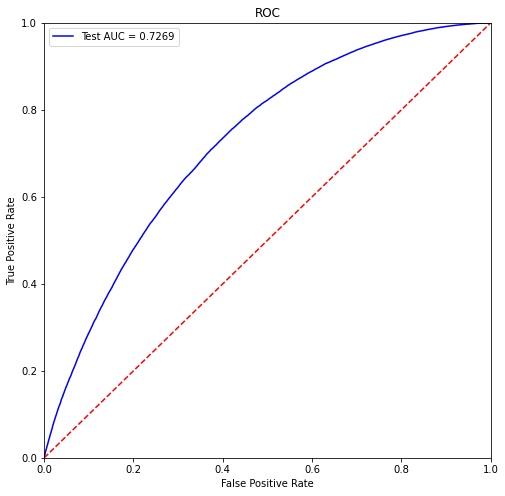

In [206]:
from sklearn import metrics
import matplotlib.pyplot as plt 
fpr, tpr, threshold = roc_curve(ground_truth, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.title('Test ROC')
plt.plot(fpr, tpr, 'b', label = 'Test AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1],[0,1],'r--')
plt.show()